# Make All Figures for Main Manuscript

Kendra Wyant  
July 31, 2025

In [ ]:

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(patchwork)

theme_set(theme_classic())

path_models_lag <- format_path(str_c("risk/models/lag"))
path_shared <- format_path("risk/data_processed/shared")
path_processed <- format_path("risk/data_processed/lag")


Data for figures

In [ ]:
pp_tidy <- read_csv(here::here(path_models_lag, "posteriors.csv"), 
                                 show_col_types = FALSE) 

ci <- read_csv(here::here(path_models_lag, "pp_perf_tibble.csv"), 
                                 show_col_types = FALSE) |> 
  mutate(model = factor(model, levels = c("0 lag", "24 lag", "72 lag", "168 lag", "336 lag"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")))

preds_0 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_0_v3_strat_lh_final.rds")) 
preds_24 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_24_v3_strat_lh_final.rds")) 
preds_72 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_72_v3_strat_lh_final.rds")) 
preds_168 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_168_v3_strat_lh_final.rds")) 
preds_336 <- read_rds(here::here(path_models_lag, 
                               "final_preds_kfold_1_x_5_1day_336_v3_strat_lh_final.rds")) 


shap_grp_0 <- read_rds(here::here(path_models_lag, 
                      "final_shapsgrp_kfold_1_x_5_1day_0_v3_strat_lh_final.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
   mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"))  

shap_grp_336 <- read_rds(here::here(path_models_lag, 
                      "final_shapsgrp_kfold_1_x_5_1day_336_v3_strat_lh_final.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"))  

shap_global <- shap_grp_0 |> 
  mutate(model = "No lag") |> 
  bind_rows(shap_grp_336 |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("2 weeks", "No lag" ))) |> 
  group_by(variable_grp, model) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop")

shap_levels <- shap_global |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()


## Figure 1: Prediction Methods

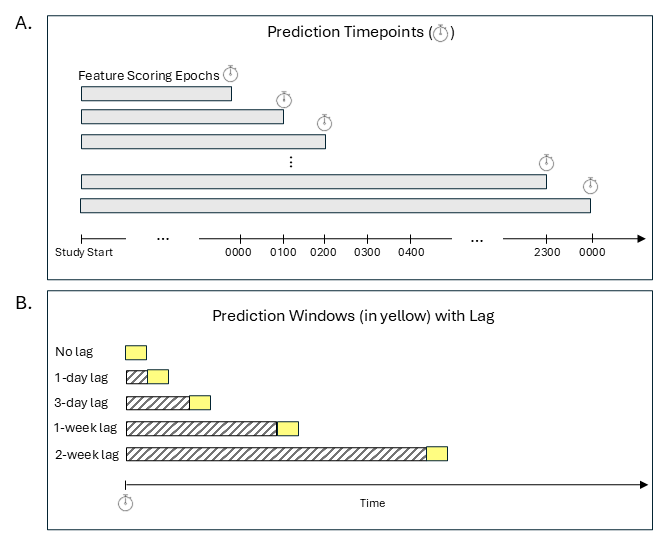

In [ ]:

knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)


## Figure 2: Posterior probabilities for auROC by model

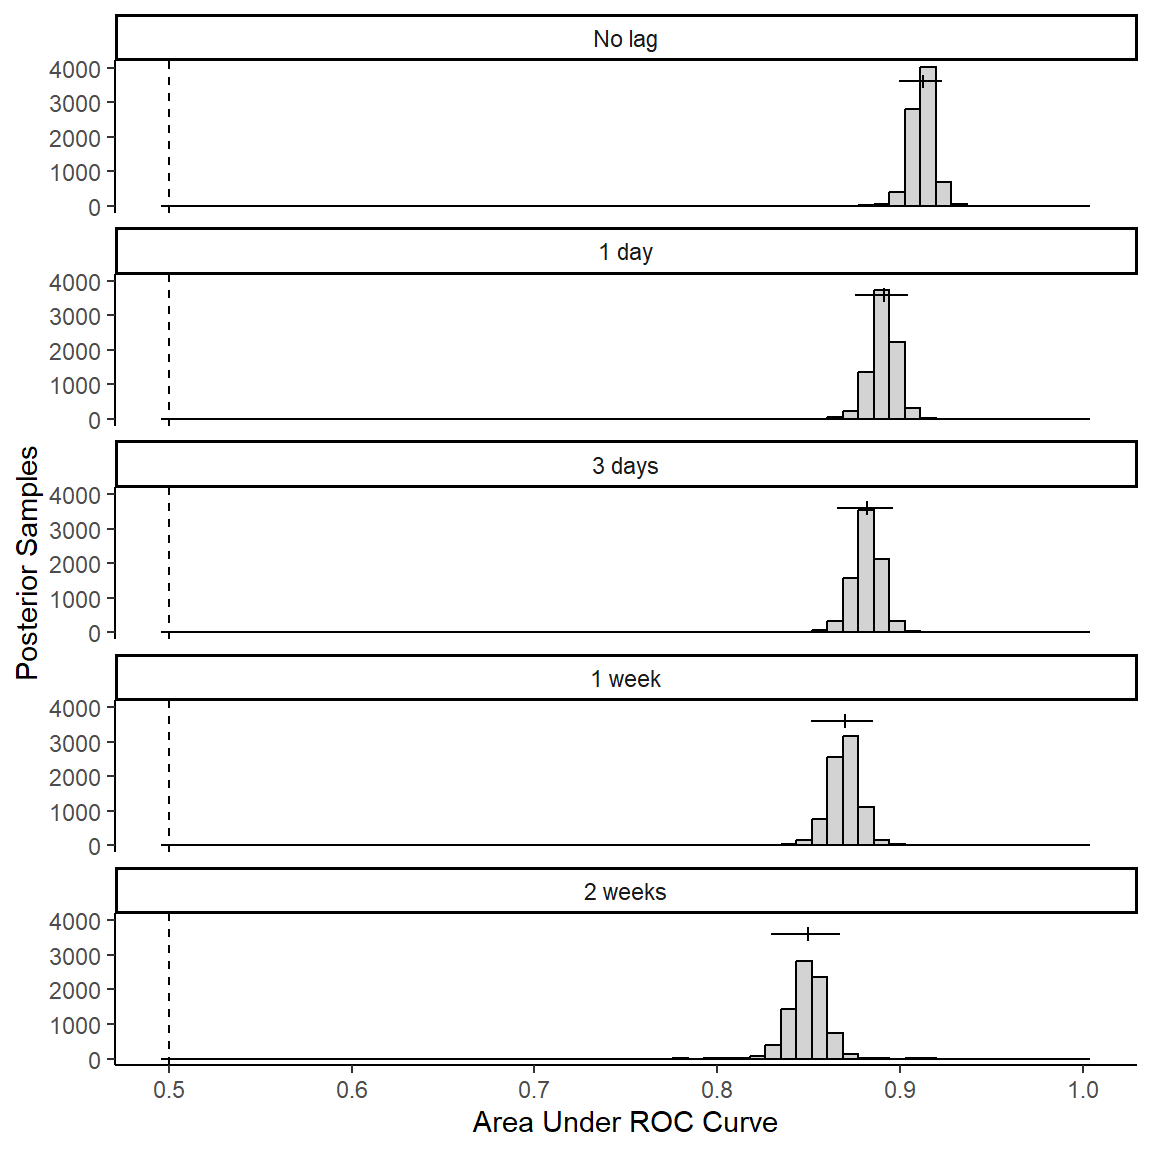

In [ ]:

pp_tidy |> 
  mutate(model = factor(model, levels = c("lag0", "lag24", "lag72", "lag168", "lag336"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior), fill = "light grey", color = "black", linewidth = .5,  
                 bins = 60) +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, data = ci) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
                linewidth = .5, data = ci) +
  facet_wrap(~model, ncol = 1) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Samples") +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() 


## Figure 3: Calibrated Model Performance

In [ ]:
bin_width = 0.10

preds_all_raw <- preds_0 |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")),
         prob = "Raw (uncalibrated)")


preds_all_logi <- preds_0 |> 
  mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  mutate(model = "No lag") |> 
  bind_rows(preds_336 |> 
              mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
                     lapse = if_else(label == "Lapse", 1, 0)) |> 
              mutate(model = "2 weeks")) |> 
  mutate(model = factor(model, levels = c("No lag", "1 day", "3 days", "1 week", "2 weeks")),
         prob = "Logistic calibration")

preds_all <- preds_all_raw |> 
  bind_rows(preds_all_logi) 

mini_hist <- preds_all_raw |>
  count(bins, model) |> 
  bind_rows(tibble(bins = "(0.9,1]",
                   model = "2 weeks",
                   n = 0)) |> 
  group_by(model) |> 
  mutate(
    bins = seq(1, 10, 1),
    x = bin_width / 2 + bin_width * (bins - 1),       
    y = n / max(n) * 0.07
  ) |> 
  mutate(model = factor(model, levels = c("No lag", "2 weeks"))) 


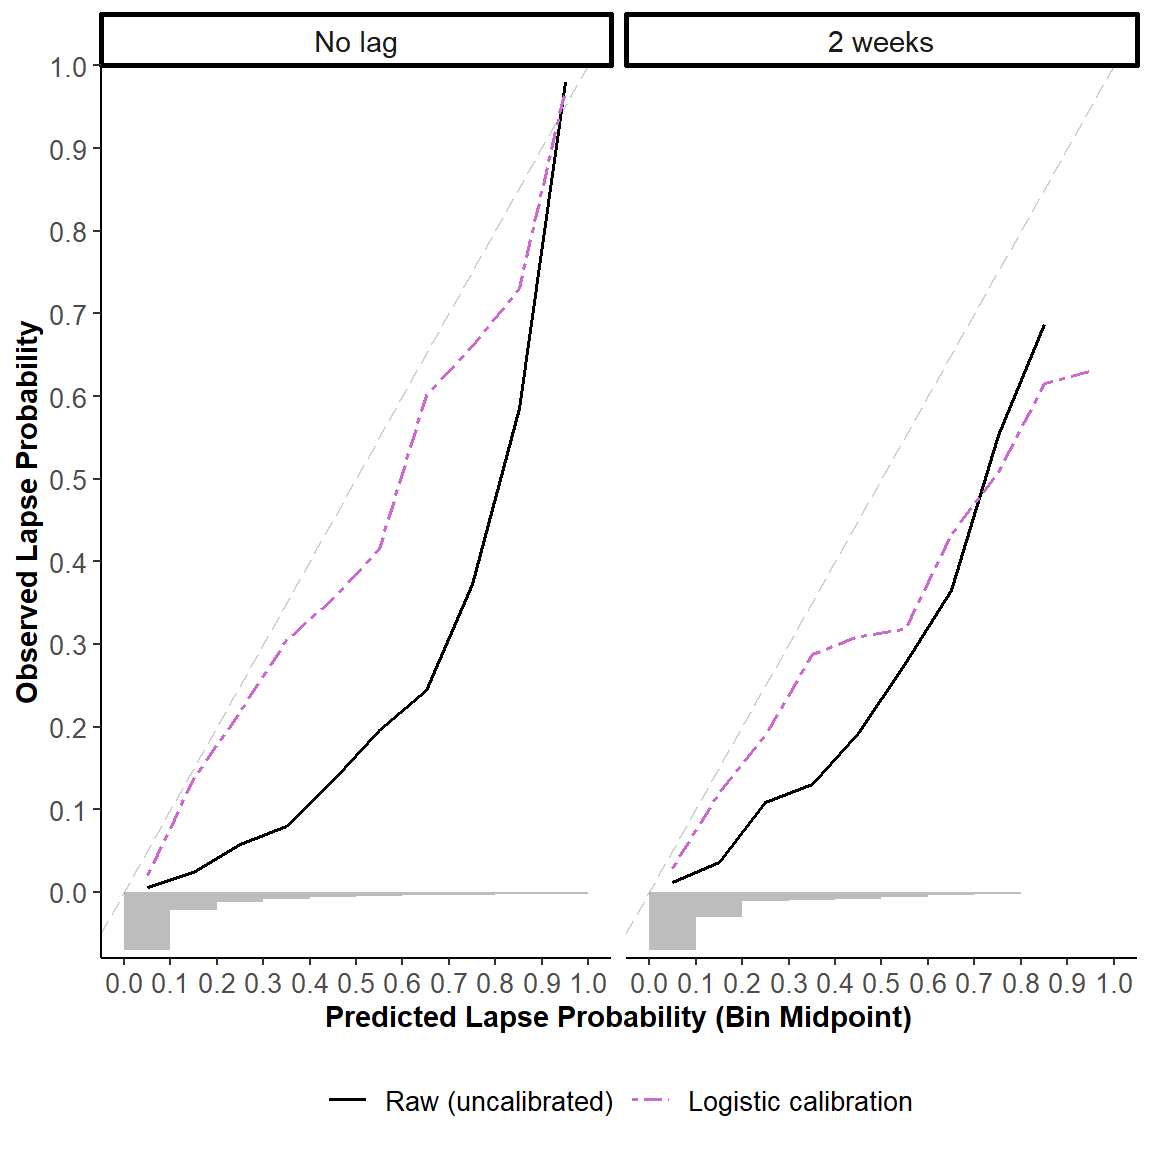

In [ ]:

preds_all |> 
  mutate(prob = factor(prob, levels = c("Raw (uncalibrated)", 
                                        "Logistic calibration"))) |> 
  group_by(bins, model, prob)  |> 
  summarize(mean_lapse = mean(lapse), .groups = "drop") |> 
  mutate(
    bins = as.numeric(bins),
    midpoints = bin_width/2 + bin_width * (bins - 1)
  )  |> 
  ggplot(aes(x = midpoints, y = mean_lapse, group = prob,
             color = prob, linetype = prob)) +
  geom_abline(slope = 1, intercept = 0, linetype = "longdash", color = "gray80") +
  geom_line(linewidth = .7) +
  geom_rect(data = mini_hist, inherit.aes = FALSE,
            aes(xmin = x - bin_width / 2,
                xmax = x + bin_width / 2,
                ymin = -y,
                ymax = 0),
            alpha = .4) +
  facet_wrap(~ model, ncol = 2) +
  labs(
    x = "Predicted Lapse Probability (Bin Midpoint)",
    y = "Observed Lapse Probability",
    color = NULL,
    linetype = NULL
  ) +
  scale_x_continuous(breaks = seq(0, 1, bin_width), limits = c(0, 1)) +
  scale_y_continuous(limits = c(-0.08, 1), breaks = seq(0,1, bin_width),
                     expand = c(0, 0)) +
  coord_cartesian(clip = "off") +
  scale_color_manual(values = c("black", "#cb6bce")) +
  scale_linetype_manual(values = c("solid", "twodash")) +
  theme_classic(base_size = 11) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 11),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 10),
    axis.title = element_text(face = "bold")
  )


## Figure 4: Global and Local Shapley Plots

In [ ]:
global_panel <- shap_global |>
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  ggplot() +
  geom_bar(aes(x = variable_grp, y = mean_value, fill = model), 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  scale_fill_manual(values = c("#458892", "#751c6d")) +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()


In [ ]:
shap_grp_0_sum <- shap_grp_0 |> 
  group_by(variable_grp) |> 
  summarize(min = min(value), max = max(value)) |> 
  mutate(model = "No lag")

shap_grp_336_sum <- shap_grp_336 |> 
  group_by(variable_grp) |> 
  summarize(min = min(value), max = max(value)) |> 
  mutate(model = "2 weeks")

panel_shap_local <- shap_grp_0_sum |>
  bind_rows(shap_grp_336_sum) |> 
  mutate(model = factor(model, levels = c("2 weeks", "No lag"))) |> 
  mutate(variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  ggplot() +
  geom_segment(aes(x = variable_grp, y = min, yend = max, group = model,
                   color = model),
               position = position_dodge(width = .5), 
               linewidth = 1) +
  ylab("Raw Shapley Value") +
  xlab(NULL) +
  labs(color = NULL) +
  scale_color_manual(values = c("#458892", "#751c6d")) +
  theme(legend.position = "none",
        axis.text=element_text(size=9.5),
        panel.border = element_rect(colour = "black", fill = NA, 
                                    linewidth = 1))+
  geom_hline(aes(yintercept = 0), linetype = "dashed",
             linewidth = .5) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-2, 6, 2)) +
  coord_flip()


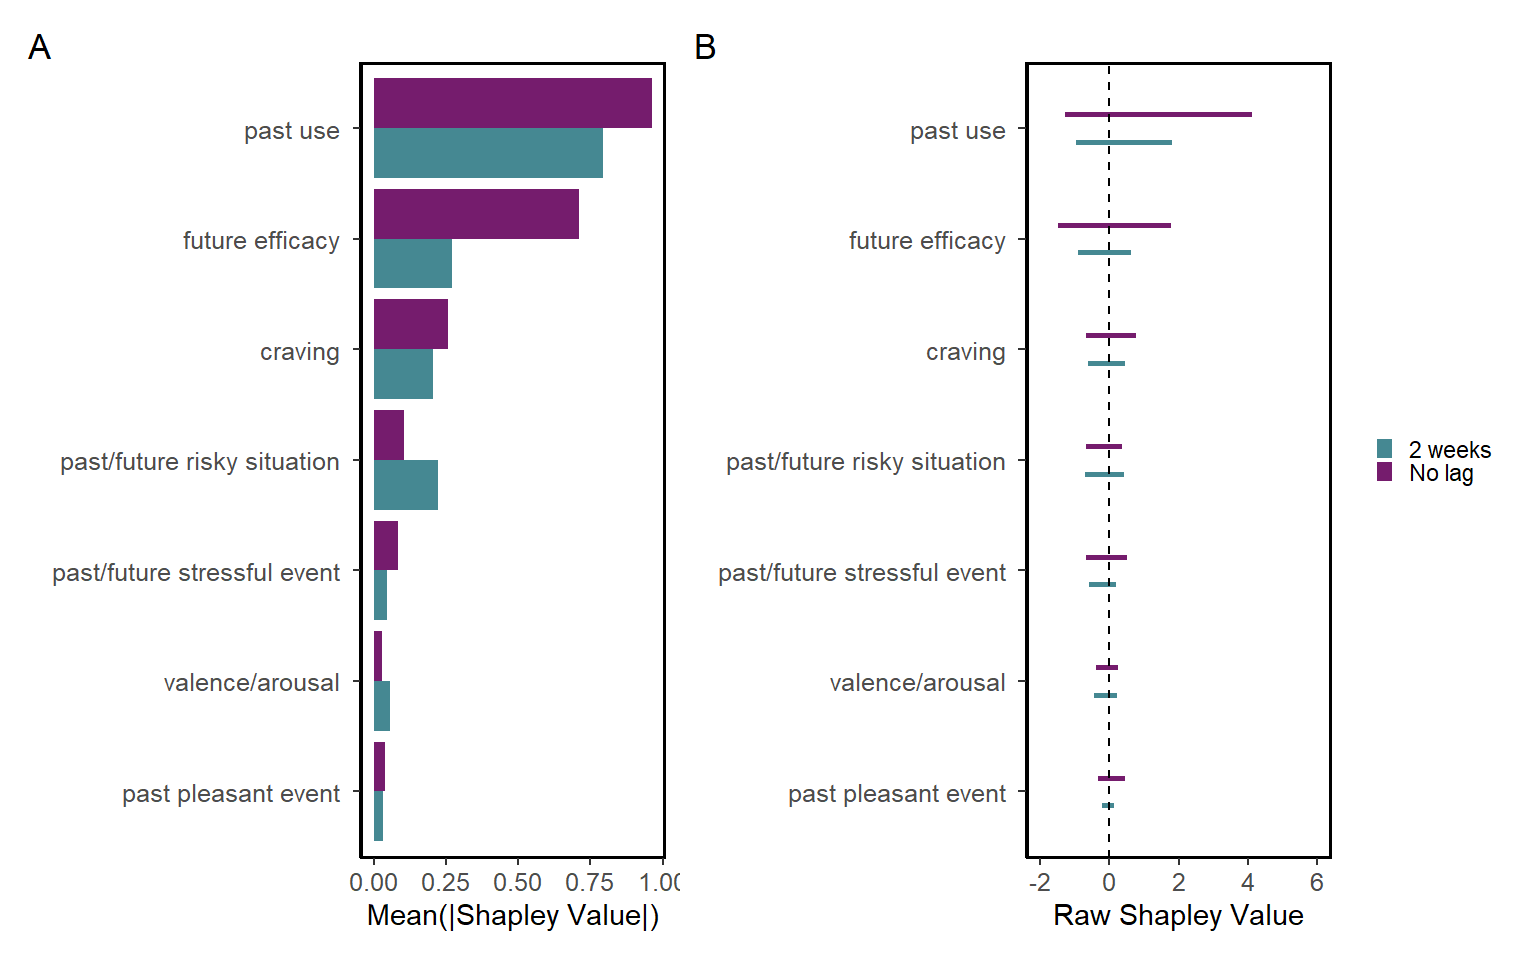

In [ ]:

global_panel + panel_shap_local + 
  plot_layout(guides = "collect") &
  plot_annotation(tag_levels = "A") 
